### Note

Real project was done to predict the customer retention of a bank after 2 years. This analysis was done on randomized data that falls within the range of the actual data in the project and not the actual data. This was done purposely to ensure that actual company data is protected and company privacy respected. Also, all columns were renamed to dummy names of the alphabet while the target column was named "target". The main aim of this project is to show the process taken in our machine learning.

All columns are numbers

1 - Customer retained,
0 - Customer lost

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

### Exploratory Data Analysis

We would try to extract as much information as we can from the data

In [3]:
print(f'Size of train set is {df_train.shape}')
print(f'Size of test set is {df_test.shape}')

Size of train set is (150000, 11)
Size of test set is (101503, 11)


Reducing memory size using type casting

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 12.59 MB
Memory usage after optimization is: 2.72 MB
Decreased by 78.4%
Memory usage of dataframe is 8.52 MB
Memory usage after optimization is: 2.52 MB
Decreased by 70.5%


In [5]:
df_train.head()

,Target,A,B,C,D,E,F,G,H,I,J
0,1,0.766113,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957031,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658203,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233765,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907227,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
df_train.columns.values

array(['Target', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
      dtype=object)

Checking for the distribution of the targets

In [7]:
for key, d in df_train.groupby('Target'):
    print(d)

        Target         A   B  C            D        E   F  G  H  I    J
1            0  0.957031  40  0     0.121876   2600.0   4  0  0  0  1.0
2            0  0.658203  38  1     0.085113   3042.0   2  1  0  0  0.0
3            0  0.233765  30  0     0.036050   3300.0   5  0  0  0  0.0
4            0  0.907227  49  1     0.024926  63588.0   7  0  1  0  0.0
5            0  0.213135  74  0     0.375607   3500.0   3  0  1  0  1.0
...        ...       ...  .. ..          ...      ...  .. .. .. ..  ...
149995       0  0.040680  74  0     0.225131   2100.0   4  0  1  0  0.0
149996       0  0.299805  44  0     0.716562   5584.0   4  0  1  0  2.0
149997       0  0.246094  58  0  3870.000000      NaN  18  0  1  0  0.0
149998       0  0.000000  30  0     0.000000   5716.0   4  0  0  0  0.0
149999       0  0.850098  64  0     0.249908   8158.0   8  0  2  0  0.0

[139974 rows x 11 columns]
        Target         A   B  C           D        E   F  G  H  I    J
0            1  0.766113  45  2    0.

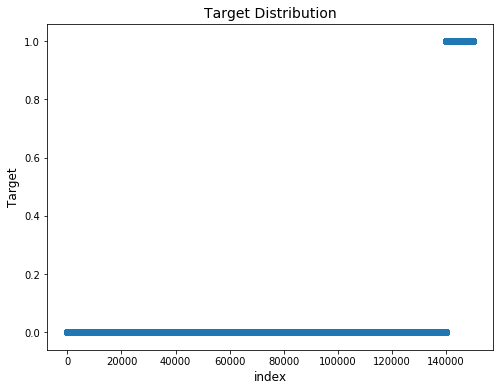

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_train.shape[0]), np.sort(df_train['Target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

We can see from the above that we have an unbalanced dataset. The number of customers they lost were **a lot more** than the number they retained. This imbalance could be a problem to our machine learning

For a better view:

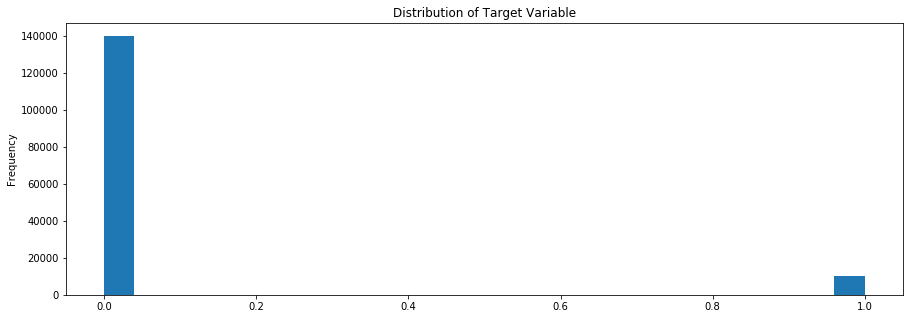

In [9]:
plt.figure(figsize = (15,5))
df_train['Target'].plot(kind='hist',
                        bins=25,
                        figsize=(15, 5),
                        title='Distribution of Target Variable')
plt.show()

Check the missing data in the train set

In [10]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data

,Total,Percent
E,29731,19.820667
J,3924,2.616000
I,0,0.000000
H,0,0.000000
G,0,0.000000
F,0,0.000000
D,0,0.000000
C,0,0.000000
B,0,0.000000
A,0,0.000000


We can see that the column with the most missing values is E with 29,731 missing, and these make up 19.8% of the data

In [11]:
df_train.dtypes.value_counts()

int8       7
float32    2
float16    2
dtype: int64

Now we check for correlation. Correlations do not actually represent "relevance" of a feature but they give us an understanding of possible relationships

In [12]:
correlations = df_train.corr()
correlations_target = correlations['Target'].sort_values()

print('Most Positive Correlations:\n', correlations_target.tail(5))
print('\nMost Negative Correlations:\n', correlations_target.head(5))
print("==========" * 5)
print("ALL CORRELATIONS:")
correlations

Most Positive Correlations:
 J         0.046048
I         0.102261
G         0.117175
C         0.125587
Target    1.000000
Name: Target, dtype: float64

Most Negative Correlations:
 B   -0.115386
F   -0.029669
E   -0.019746
D   -0.007602
H   -0.007038
Name: Target, dtype: float64
ALL CORRELATIONS:


,Target,A,B,C,D,E,F,G,H,I,J
Target,1.000000,-0.001801,-0.115386,0.125587,-0.007602,-0.019746,-0.029669,0.117175,-0.007038,0.102261,0.046048
A,-0.001801,1.000000,-0.005898,-0.001314,0.003961,0.007124,-0.011280,-0.001061,0.006235,-0.001048,0.001558
B,-0.115386,-0.005898,1.000000,-0.062995,0.024188,0.037717,0.147705,-0.061005,0.033150,-0.057159,-0.213303
C,0.125587,-0.001314,-0.062995,1.000000,-0.006542,-0.010217,-0.055312,0.983603,-0.030565,0.987005,-0.002680
D,-0.007602,0.003961,0.024188,-0.006542,1.000000,-0.028712,0.049565,-0.008320,0.120046,-0.007533,-0.040673
E,-0.019746,0.007124,0.037717,-0.010217,-0.028712,1.000000,0.091455,-0.012743,0.124959,-0.011116,0.062647
F,-0.029669,-0.011280,0.147705,-0.055312,0.049565,0.091455,1.000000,-0.079984,0.433959,-0.071077,0.065322
G,0.117175,-0.001061,-0.061005,0.983603,-0.008320,-0.012743,-0.079984,1.000000,-0.045205,0.992796,-0.010176
H,-0.007038,0.006235,0.033150,-0.030565,0.120046,0.124959,0.433959,-0.045205,1.000000,-0.039722,0.124684
I,0.102261,-0.001048,-0.057159,0.987005,-0.007533,-0.011116,-0.071077,0.992796,-0.039722,1.000000,-0.010922


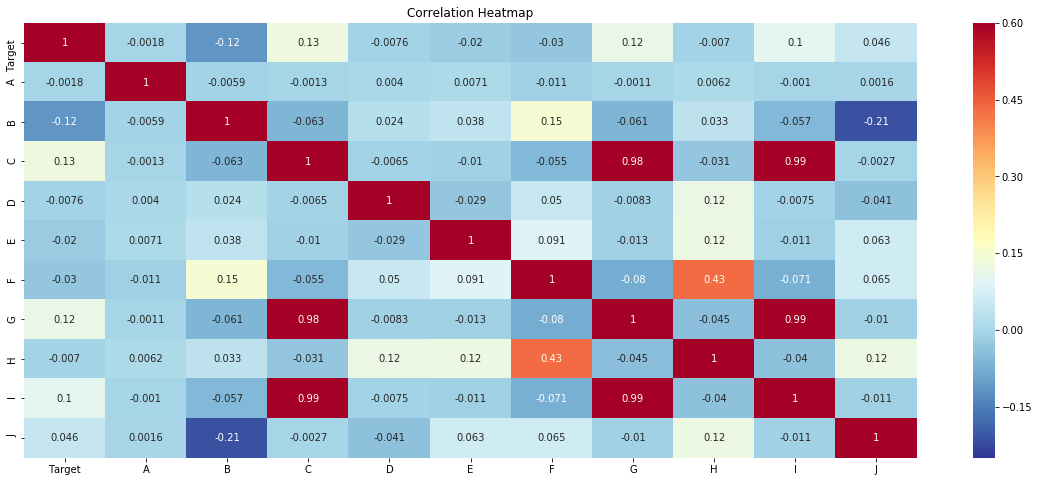

In [13]:
plt.figure(figsize = (20, 8))

# Heatmap of correlations
sns.heatmap(correlations, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

In [14]:
def plot_dist_col(column):
    """
    Plot dist curves for train and test set for a given column name
    """
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df_train[column].dropna(), color='green', ax=ax).set_title(f"dist plot for {column}", fontsize=16)
    sns.distplot(df_test[column].dropna(), color='purple', ax=ax).set_title(f"dist plot for {column}", fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

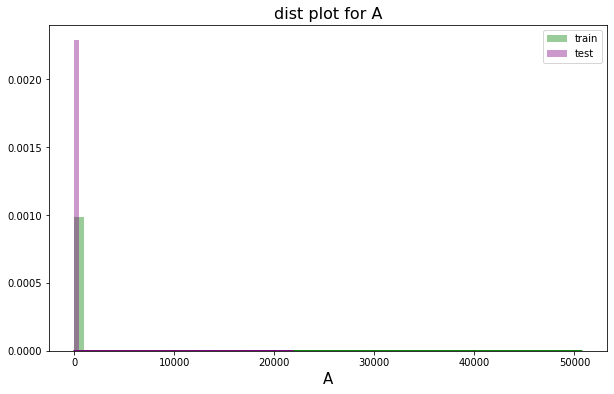

In [15]:
plot_dist_col('A')

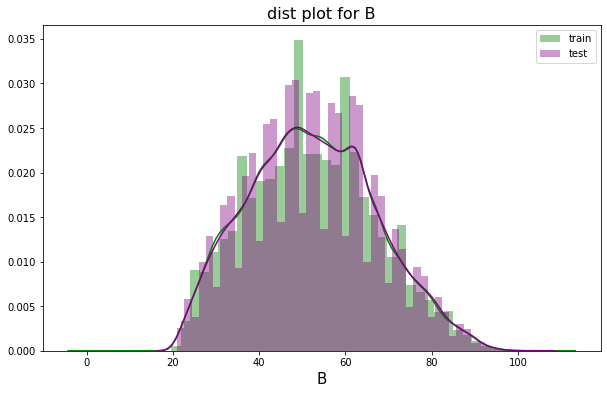

In [16]:
plot_dist_col('B')

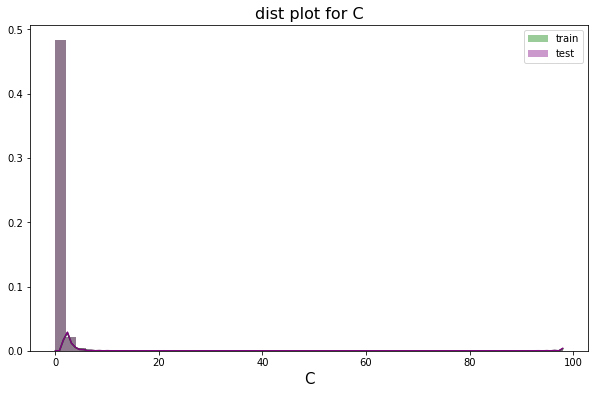

In [17]:
plot_dist_col('C')

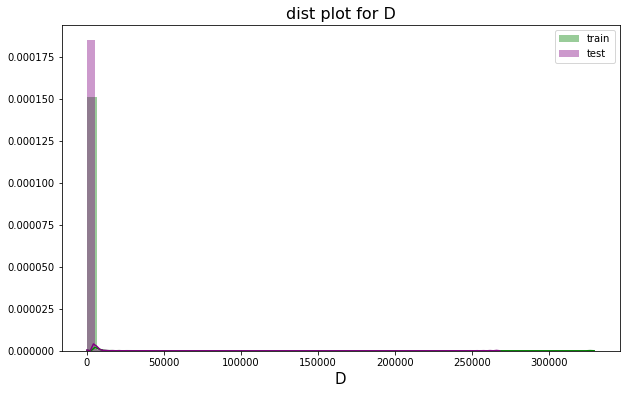

In [18]:
plot_dist_col('D')

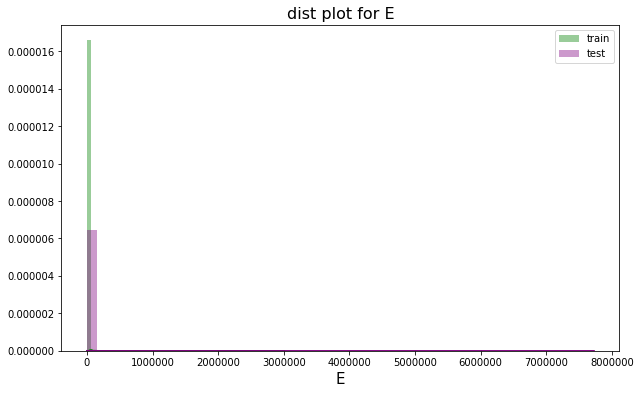

In [19]:
plot_dist_col('E')

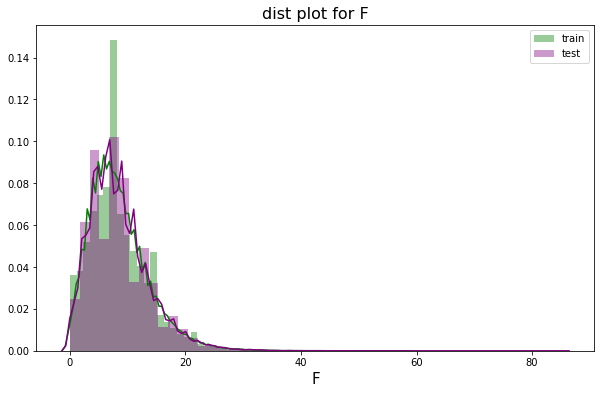

In [20]:
plot_dist_col('F')

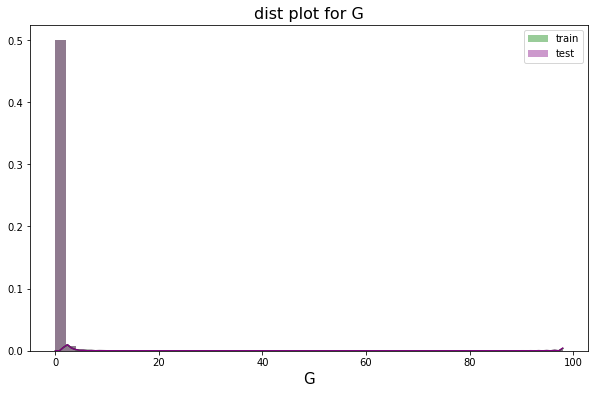

In [21]:
plot_dist_col('G')

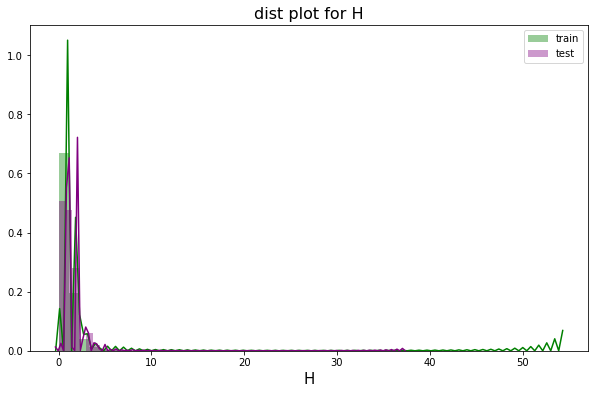

In [22]:
plot_dist_col('H')

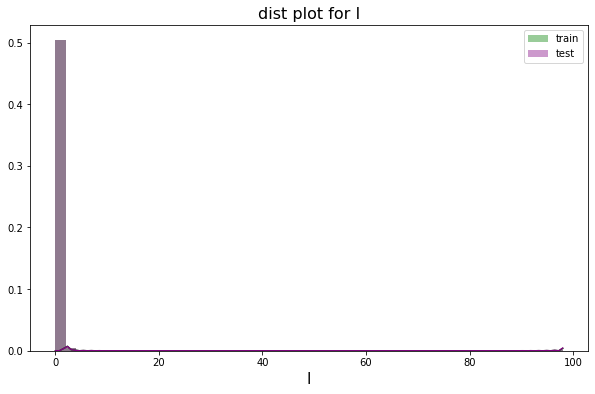

In [23]:
plot_dist_col('I')

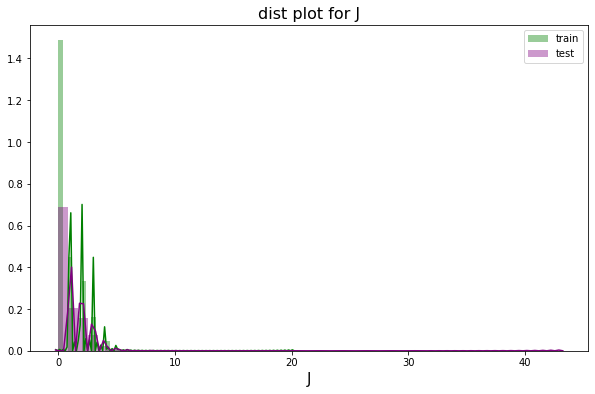

In [24]:
plot_dist_col('J')

We can see from the distributions above that columns A and E have different distributions, B, D, F, H, J have relatable distributions whereas C, G, I have matching distributions. This will be further confirmed below:

In [25]:
def confirm_distributions(col):
    col_train_min = df_train[col].min()
    col_train_max = df_train[col].max()
    col_train_std = df_train[col].std()
    col_test_min = df_test[col].min()
    col_test_max = df_test[col].max()
    col_test_std = df_test[col].std()
    col_min = [col_train_min, col_test_min]
    col_max = [col_train_max, col_test_max]
    col_std = [col_train_std, col_test_std]
    df = pd.DataFrame({'min': col_min, 'max': col_max, 'std':col_std})
    df = df.rename(index={0: 'train', 1:'test'})
    print(df)
    return "done"


for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
    print(f"Statistics for {i}")
    print(confirm_distributions(i))
    print("==================" * 5)

Statistics for A
       min      max  std
train  0.0  50720.0  NaN
test   0.0  21824.0  NaN
done
Statistics for B
       min  max        std
train    0  109  14.771866
test    21  104  14.779756
done
Statistics for C
       min  max       std
train    0   98  4.192781
test     0   98  4.538487
done
Statistics for D
       min       max          std
train  0.0  329664.0  2038.782471
test   0.0  268326.0  1631.990845
done
Statistics for E
       min        max           std
train  0.0  3008750.0  14383.863281
test   0.0  7727000.0  36506.277344
done
Statistics for F
       min  max       std
train    0   58  5.145951
test     0   85  5.144100
done
Statistics for G
       min  max       std
train    0   98  4.169304
test     0   98  4.515859
done
Statistics for H
       min  max       std
train    0   54  1.129771
test     0   37  1.110253
done
Statistics for I
       min  max       std
train    0   98  4.155179
test     0   98  4.503578
done
Statistics for J
       min   max  std
train  

Notice how the statistics above confirm our images when you compare the min, max and std of the distributions in the train and test set per column

Due to knowing what each feature represented, more EDA was carried out on various columns. For instance there were outliers present in B. It simply was not possible for B to have values less than 18, deciding to set a reasonable upper limit of 80. The goal to group people that possess values of B to know the percentage of those that are retained

In [26]:
"""
The row containing a value of B less than 18 in the training set
is only 1, and it does not exist in the test set so it will be dropped
"""
df_train = df_train.loc[~df_train['B'] < 18]

B_interval = [[18, 30],
              [30, 40],
              [40, 50],
              [50, 60],
              [60, 70],
              [70, 80],
              [80, 90],
              [90, 100],
              [100, 110]]

total_num = len(df_train)
for i in B_interval:
    data = df_train.query(f"B>={i[0]} and B<{i[1]}")
    retained = data['Target'].value_counts().values[1]
    perc = retained * 100 / total_num
    print(f"for range {i[0]} to {i[1]}, {perc:.2f}% are usually retained")

for range 18 to 30, 0.69% are usually retained
for range 30 to 40, 1.56% are usually retained
for range 40 to 50, 1.92% are usually retained
for range 50 to 60, 1.52% are usually retained
for range 60 to 70, 0.70% are usually retained
for range 70 to 80, 0.22% are usually retained
for range 80 to 90, 0.07% are usually retained
for range 90 to 100, 0.01% are usually retained
for range 100 to 110, 0.00% are usually retained


### Feature Engineering

We would start off by taking care of missing data. Missing data only occur in the columns E and J in both train and test set, they would be filled by numbers not present within their distributions. This would help xgboost treat "missingness" as it's own feature

In [27]:
df_train['E'] = df_train['E'].fillna(-999).astype(np.int16)
df_test['E'] = df_test['E'].fillna(-999).astype(np.int16)

df_train['J'] = df_train['J'].fillna(-999).astype(np.int16)
df_test['J'] = df_test['J'].fillna(-999).astype(np.int16)

In [28]:
"""
Groupings for B
"""
def group_col(x):
    if ((x>=18 and x<30) or (x>=60 and x<70)):
        return "one"
    elif ((x>=30 and x<40) or (x>=40 and x<50) or (x>=50 and x<60)):
        return "two"
    else:
        return "three"
        
df_train['B_group'] = df_train['B'].apply(group_col)
df_test['B_group'] = df_test['B'].apply(group_col)

In [60]:
## this is where i am, map the stats gotten from the training set into the test
df_group =  df_train.groupby('B_group')['B']
B_group_min = df_group.min().astype(np.float16).to_dict()
B_group_mean = df_group.mean().astype(np.float16).to_dict()
B_group_median = df_group.median().astype(np.float16).to_dict()
B_group_std = df_group.std().astype(np.float16).to_dict()
B_group_max = df_group.max().astype(np.float16).to_dict()
B_group_count = df_group.count().to_dict()


def add_stat_feats(df):
    df['group_min'] = df['B_group'].map(B_group_min)
    df['group_mean'] = df['B_group'].map(B_group_mean)
    df['group_median'] = df['B_group'].map(B_group_median)
    df['group_std'] = df['B_group'].map(B_group_std)
    df['group_max'] = df['B_group'].map(B_group_max)
    df['group_count'] = df['B_group'].map(B_group_count)
    return df
    
df_train = add_stat_feats(df_train)
df_test = add_stat_feats(df_test)

In [62]:
df_test.sample(15)

,Target,A,B,C,D,E,F,G,H,I,J,B_group,group_min,group_mean,group_median,group_std,group_max,group_count
91523,NaN,0.016434,40,0,0.231083,12250,6,0,2,0,2,two,30.0,45.93750,47.0,8.164062,59.0,92861
96985,NaN,0.024841,85,0,0.015330,4500,4,0,1,0,0,three,0.0,77.12500,76.0,5.839844,109.0,19414
75475,NaN,0.148193,57,0,0.203067,3781,11,0,1,0,1,two,30.0,45.93750,47.0,8.164062,59.0,92861
98531,NaN,0.240967,66,0,0.333909,1736,5,0,0,0,0,one,21.0,55.15625,62.0,16.171875,69.0,37725
74187,NaN,0.026413,41,0,94.000000,-999,5,0,0,0,0,two,30.0,45.93750,47.0,8.164062,59.0,92861
39726,NaN,0.014664,55,0,0.000640,9375,3,0,0,0,0,two,30.0,45.93750,47.0,8.164062,59.0,92861
10502,NaN,0.000000,30,0,0.000000,3000,2,0,0,0,3,two,30.0,45.93750,47.0,8.164062,59.0,92861
68053,NaN,0.149170,26,1,0.110297,3000,4,0,0,0,0,one,21.0,55.15625,62.0,16.171875,69.0,37725
94390,NaN,0.012611,50,0,2440.000000,-999,4,0,2,0,0,two,30.0,45.93750,47.0,8.164062,59.0,92861
57471,NaN,0.009331,57,0,0.331274,11168,8,0,2,0,1,two,30.0,45.93750,47.0,8.164062,59.0,92861


In [63]:
df_train = df_train.drop(['B_group'], axis='columns')
df_test = df_test.drop(['B_group'], axis='columns')

In [69]:
# target = df_train['Target'].copy()
# df_train = df_train.drop('Target', axis='columns')

In [70]:
kf = KFold(n_splits=10, shuffle=True)
for train_idx, val_idx in kf.split(df_train):
    X_train, X_val = df_train[train_idx], df_train[val_idx]
    y_train, y_val = target[train_idx], target[val_idx]
    xgb_model = xgb.XGBRegressor(
                    metric='reg:squarederror',
                    n_estimators=500,
                    max_depth=20,
                    importance_type="gain",
                    learning_rate=0.05,
                    eval_set = [(X_val, y_val)],
                    early_stopping_rounds=100,
                    verbose=True
                )
    print("Starting predictions round")
    xgb_model.fit(X_train, y_train, verbose=True)

Starting predictions round
[11:53:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
with open('model2.pkl', 'wb') as filename:
    pickle.dump(xgb_model, filename)

In [ ]:
feature_importance = xgb_model.feature_importances_
train_features = train.drop('Target', axis=1).columns

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=train_features)
